L1 based models for Sparse Signals where thre are mere features then the test data that makes the solution un deterministic

In [9]:
import numpy as np


rng = np.random.RandomState(0)
n_samples, n_features, n_informative = 50, 100, 10 # number of samples, features and informative features
time_step = np.linspace(0, 1, n_samples) # time steps
freqs = 2 * np.pi * np.sort(rng.rand(n_features))/0.01 # frequencies
X = np.zeros((n_samples, n_features)) # initialize the feature matrix
for i in range(n_features):
    X[:, i] = np.sin(freqs[i] * time_step) # fill the feature matrix with sine waves

idx = np.arange(n_features)
true_coefs = (-1) ** idx * np.exp(-idx / 10) # true coefficients
true_coefs[n_informative:] = 0 # set non-informative coefficients to
y = np.dot(X, true_coefs) # generate the target variable

#print(y)

A random phase is introduced using some gaussian noise

In [10]:
for i in range(n_features):
    X[:, i] = np.sin(freqs[i] * time_step + 2*(rng.random_sample() - 0.5))
    X[:, i] += 0.2 * rng.normal(0,1,n_samples) # add some noise

y += 0.2 * rng.normal(0, 1, n_samples) # add some noise to the target variable

Plotting

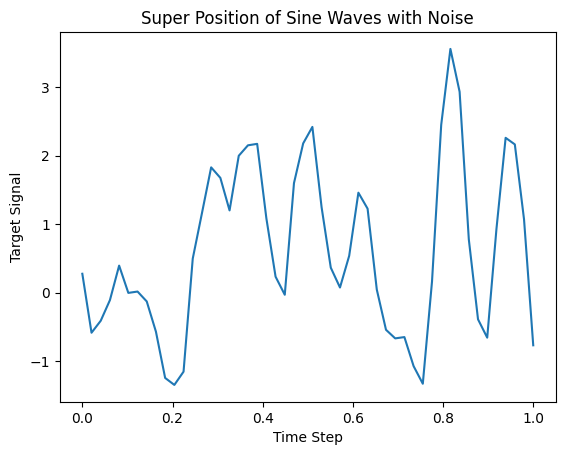

In [4]:
import matplotlib.pyplot as plt
plt.plot(time_step, y)
plt.ylabel('Target Signal')
plt.xlabel('Time Step')
_=plt.title('Super Position of Sine Waves with Noise')

Train and test but not use train to suceed test due to temporal relationship

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle = False) # Setting shuffle to False to maintain the time series order

Lasso - Getting into Lasso now

In [7]:
from time import time

from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

t0 = time()
lasso = Lasso(alpha=0.14).fit(X_train, y_train)
print(f"Lasso model fitted in {(time()-t0):.3f}s")

y_pred_lasso = lasso.predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(f"Lasso R^2 score on test set: {r2_score_lasso:.3f}")

Lasso model fitted in 0.003s
Lasso R^2 score on test set: -0.045


ARD - Baysian versio of Lasso with Gaussian noise

In [11]:
from sklearn.linear_model import ARDRegression

t0 = time()
ard = ARDRegression().fit(X_train, y_train)
print(f"ARD fit done in {(time() - t0):.3f}s")

y_pred_ard = ard.predict(X_test)
r2_score_ard = r2_score(y_test, y_pred_ard)
print(f"ARD r^2 on test data : {r2_score_ard:.3f}")

ARD fit done in 0.020s
ARD r^2 on test data : 0.248


ElasticNet - middleground between Lasso and Ridge using L1 and L2 penalty

In [8]:
from sklearn.linear_model import ElasticNet

t0 = time()
enet = ElasticNet(alpha=0.08, l1_ratio=0.5).fit(X_train, y_train)
print(f"ElasticNet fit done in {(time() - t0):.3f}s")

y_pred_enet = enet.predict(X_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
print(f"ElasticNet r^2 on test data : {r2_score_enet:.3f}")

ElasticNet fit done in 0.004s
ElasticNet r^2 on test data : -0.005


Plot and analysis

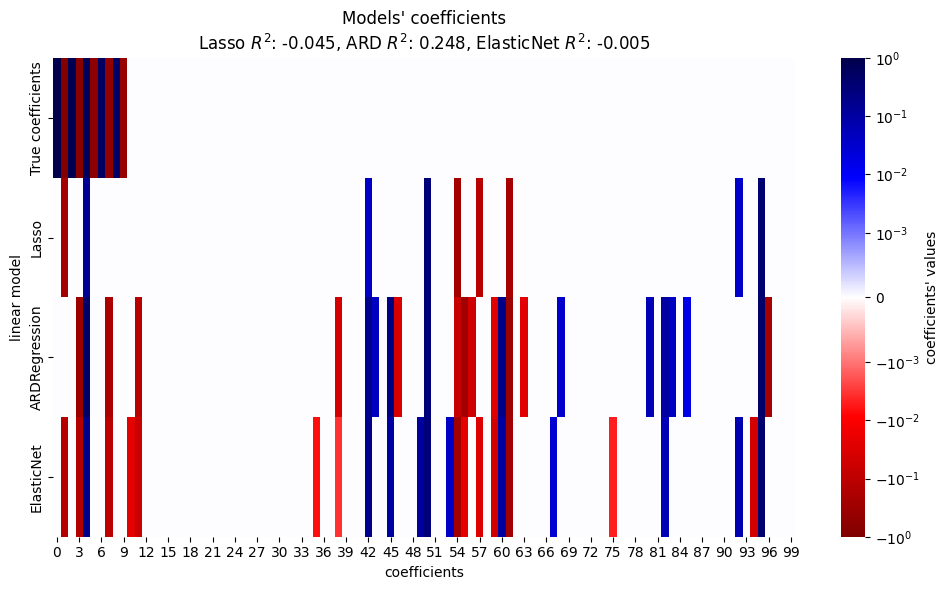

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.colors import SymLogNorm

df = pd.DataFrame(
    {
        "True coefficients": true_coefs,
        "Lasso": lasso.coef_,
        "ARDRegression": ard.coef_,
        "ElasticNet": enet.coef_,
    }
)

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    df.T,
    norm=SymLogNorm(linthresh=10e-4, vmin=-1, vmax=1),
    cbar_kws={"label": "coefficients' values"},
    cmap="seismic_r",
)
plt.ylabel("linear model")
plt.xlabel("coefficients")
plt.title(
    f"Models' coefficients\nLasso $R^2$: {r2_score_lasso:.3f}, "
    f"ARD $R^2$: {r2_score_ard:.3f}, "
    f"ElasticNet $R^2$: {r2_score_enet:.3f}"
)
plt.tight_layout()